# E-commerce Website Demand Forecasting

## 1. Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.express as px
import time
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('ecommerce.csv')

In [3]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


## 2. Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

### 2.1 Feature Analysis

In [5]:
df['Segment'].value_counts()

Consumer       5101
Corporate      2953
Home Office    1746
Name: Segment, dtype: int64

In [6]:
df['Region'].value_counts()

West       3140
East       2785
Central    2277
South      1598
Name: Region, dtype: int64

In [7]:
df['Category'].value_counts()

Office Supplies    5909
Furniture          2078
Technology         1813
Name: Category, dtype: int64

In [8]:
df['Sub-Category'].value_counts()

Binders        1492
Paper          1338
Furnishings     931
Phones          876
Storage         832
Art             785
Accessories     756
Chairs          607
Appliances      459
Labels          357
Tables          314
Envelopes       248
Bookcases       226
Fasteners       214
Supplies        184
Machines        115
Copiers          66
Name: Sub-Category, dtype: int64

In [9]:
df['Ship Mode'].value_counts()

Standard Class    5859
Second Class      1902
First Class       1501
Same Day           538
Name: Ship Mode, dtype: int64

### 2.2 Visual Analysis

#### 2.2.1 Geographic Mapping

In [10]:
pio.renderers.default = 'notebook_connected'


# Create a mapping for all 50 states 
all_state_mapping = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL",
    "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA",
    "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN",
    "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV",
    "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY",
    "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC",
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT",
    "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY"
}

# Add the Abbreviation column to the DataFrame
df['Abbreviation'] = df['State'].map(all_state_mapping)

# Group by state and calculate the sum of sales
sum_of_sales = df.groupby('State')['Sales'].sum().reset_index()

# Add Abbreviation to sum_of_sales
sum_of_sales['Abbreviation'] = sum_of_sales['State'].map(all_state_mapping)

# Create a choropleth map using Plotly
fig = go.Figure(data=go.Choropleth(
    locations=sum_of_sales['Abbreviation'],
    locationmode='USA-states',
    z=sum_of_sales['Sales'],
    hoverinfo='location+z',
     showscale=True,
     colorscale='sunsetdark' 
))

fig.update_geos(projection_type="albers usa")
fig.update_layout(
    geo_scope='usa',
    title='Total Sales by U.S. State'
)

fig.show()

#### 2.2.2 Highest Sales per State

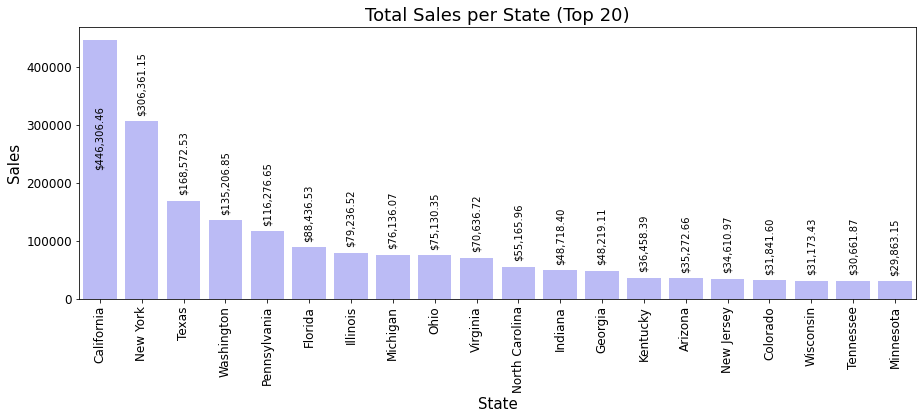

In [11]:
# Group by state and calculate the sum of sales
sum_of_sales = df.groupby('State')['Sales'].sum().reset_index()

# Sort the DataFrame by the 'Sales' column in descending order
sum_of_sales = sum_of_sales.sort_values(by='Sales', ascending=False)

# Create a horizontal bar graph
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='State', y='Sales', data=sum_of_sales[:20], ci=None, color='blue', alpha=0.3)

# Add sales values on top of each bar
for index, bar in enumerate(ax.patches):
    sales_value = bar.get_height()  # Get height (sales value) of each bar
    if sales_value>400000:
        ax.text(bar.get_x() + bar.get_width() / 2, sales_value-sales_value//2,  # X and Y coordinates for label placement
            f'${sales_value:,.2f}', ha='center', va='bottom',  # Center horizontally and vertically above the bar
            rotation=90, fontsize=10, color='black')  # Rotate label by 90 degrees
    else:
        ax.text(bar.get_x() + bar.get_width() / 2, sales_value+10000,  # X and Y coordinates for label placement
                f'${sales_value:,.2f}', ha='center', va='bottom',  # Center horizontally and vertically above the bar
                rotation=90, fontsize=10, color='black')  # Rotate label by 90 degrees

plt.xlabel('State', fontsize=15)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

plt.ylabel('Sales', fontsize=15)
plt.title('Total Sales per State (Top 20)', fontsize=18)
plt.show()


#### 2.2.3 Highest Sales per City

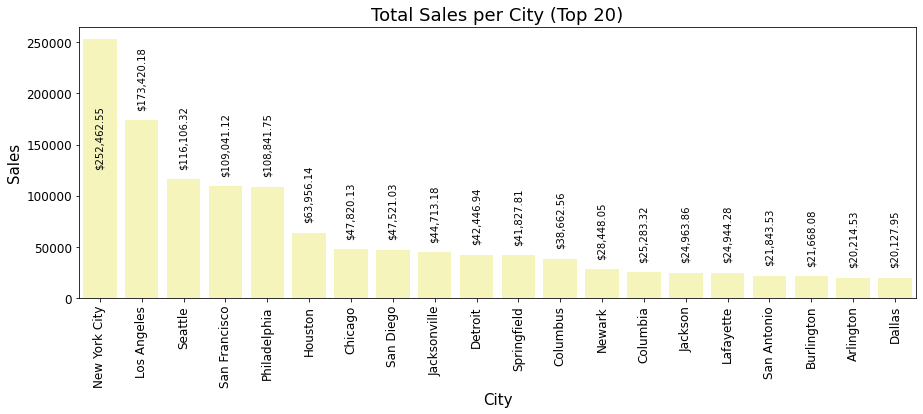

In [12]:
# Group by state and calculate the sum of sales
sum_of_sales = df.groupby('City')['Sales'].sum().reset_index()

# Sort the DataFrame by the 'Sales' column in descending order
sum_of_sales = sum_of_sales.sort_values(by='Sales', ascending=False)

# Create a horizontal bar graph
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='City', y='Sales', data=sum_of_sales[:20], ci=None, color='yellow', alpha=0.3)

# Add sales values on top of each bar
for index, bar in enumerate(ax.patches):
    sales_value = bar.get_height()  # Get height (sales value) of each bar
    if sales_value>250000:
        ax.text(bar.get_x() + bar.get_width() / 2, sales_value-sales_value//2,  # X and Y coordinates for label placement
            f'${sales_value:,.2f}', ha='center', va='bottom',  # Center horizontally and vertically above the bar
            rotation=90, fontsize=10, color='black')  # Rotate label by 90 degrees
    else:
        ax.text(bar.get_x() + bar.get_width() / 2, sales_value+10000,  # X and Y coordinates for label placement
                f'${sales_value:,.2f}', ha='center', va='bottom',  # Center horizontally and vertically above the bar
                rotation=90, fontsize=10, color='black')  # Rotate label by 90 degrees

plt.xlabel('City', fontsize=15)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

plt.ylabel('Sales', fontsize=15)
plt.title('Total Sales per City (Top 20)', fontsize=18)
plt.show()

#### 2.2.4 Highest Sales per Customer

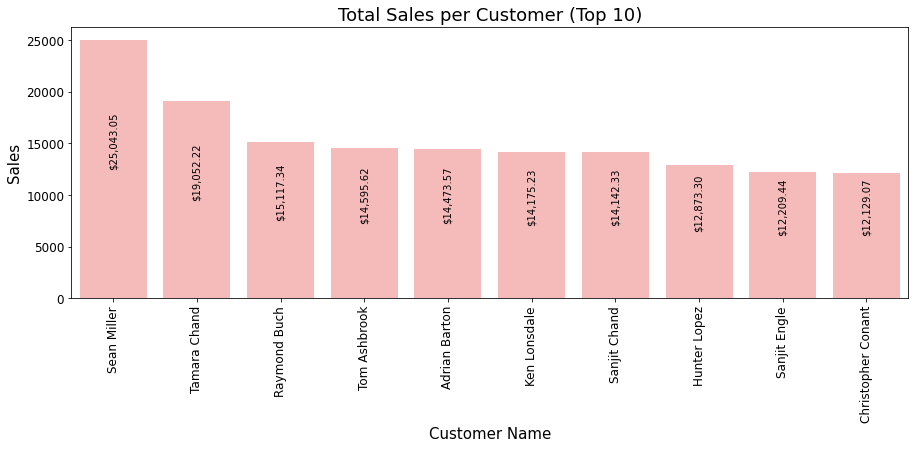

In [13]:
# Group by state and calculate the sum of sales
sum_of_sales = df.groupby('Customer Name')['Sales'].sum().reset_index()

# Sort the DataFrame by the 'Sales' column in descending order
sum_of_sales = sum_of_sales.sort_values(by='Sales', ascending=False)

# Create a horizontal bar graph
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='Customer Name', y='Sales', data=sum_of_sales[:10], ci=None, color='red', alpha=0.3)

# Add sales values on top of each bar
for index, bar in enumerate(ax.patches):
    sales_value = bar.get_height()  # Get height (sales value) of each bar
    ax.text(bar.get_x() + bar.get_width() / 2, sales_value-sales_value//2,  # X and Y coordinates for label placement
            f'${sales_value:,.2f}', ha='center', va='bottom',  # Center horizontally and vertically above the bar
            rotation=90, fontsize=10, color='black')  # Rotate label by 90 degrees

plt.xlabel('Customer Name', fontsize=15)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)


plt.ylabel('Sales', fontsize=15)
plt.title('Total Sales per Customer (Top 10)', fontsize=18)
plt.show()

#### 2.2.5 Total Sales across multiple features

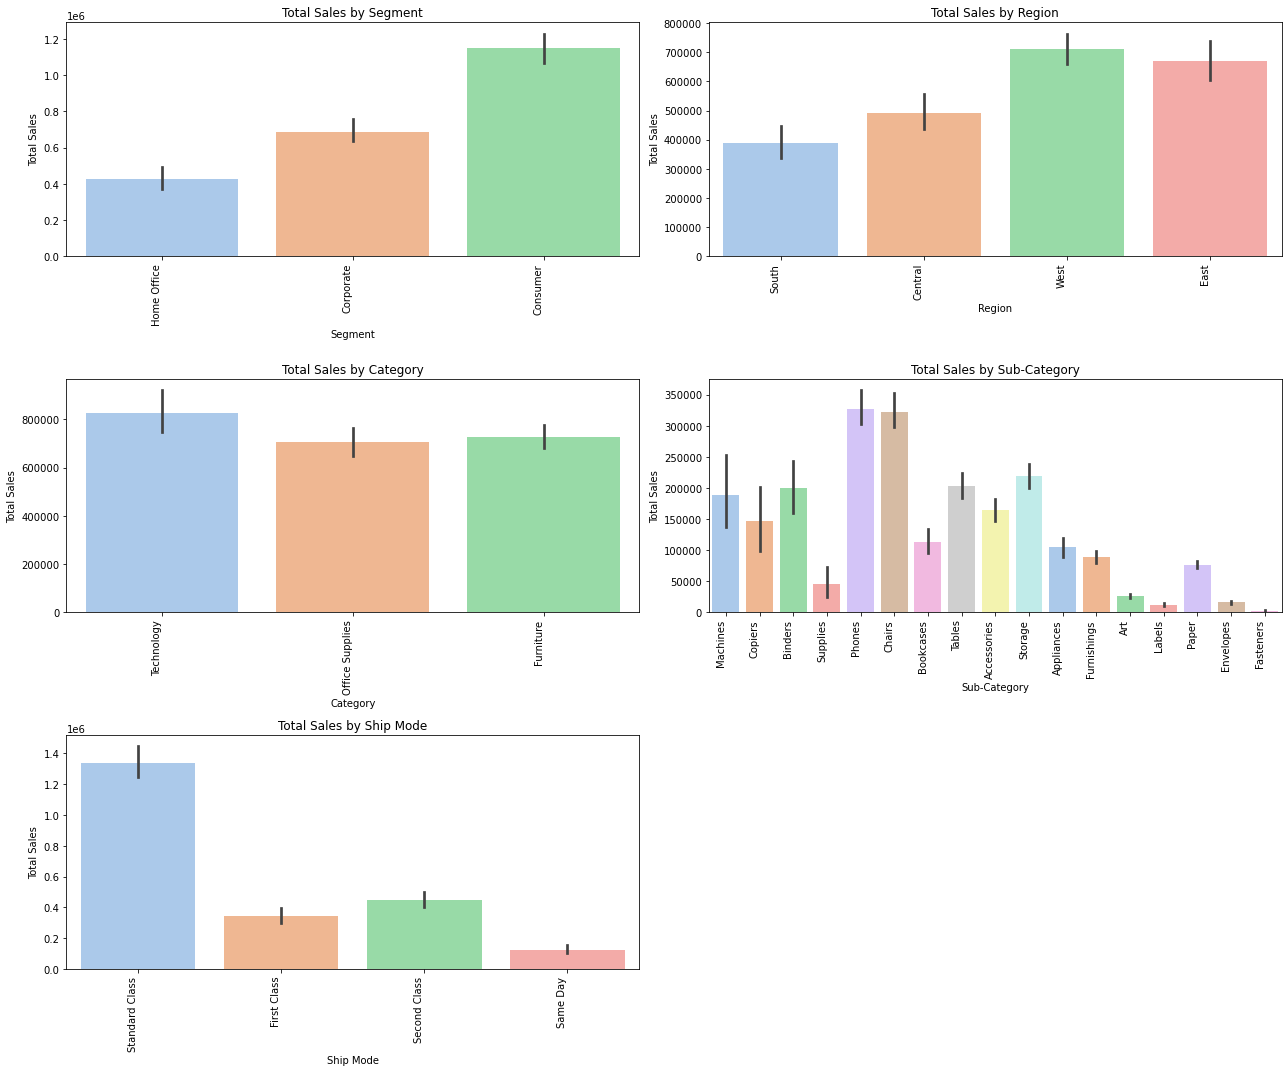

In [14]:
# Sort the DataFrame by 'Sales' in descending order
df = df.sort_values(by='Sales', ascending=False)

# Create a 3x2 grid of subplots (2 plots per row)
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

# List of columns to plot
columns = ['Segment', 'Region', 'Category', 'Sub-Category', 'Ship Mode']

# Create barplots for each column
for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]  # Adjust for 2 columns per row
    sns.barplot(x=column, y='Sales', data=df, estimator=np.sum, palette='pastel', ax=ax)
    ax.set_ylabel('Total Sales')
    ax.set_title(f'Total Sales by {column}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

# Remove the empty subplot (last subplot that won't be used)
fig.delaxes(axes[2, 1])

# Automatically adjust the layout for proper alignment and spacing
plt.tight_layout()

# Display the plots
plt.show()


#### 2.2.6 Total Sales across Categories (and Sub Categories)

In [15]:
df_summary = df.groupby(['Category', 'Sub-Category'])['Sales'].sum().reset_index()
fig = px.sunburst(
    df_summary,
    path=['Category', 'Sub-Category'],
    values='Sales',
    title='Total Sales Category (and Sub-Category) Distribution'
)

fig.show()

## 3. Data Cleaning

In [16]:
df = pd.read_csv('ecommerce.csv')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [17]:
df.drop('Row ID',axis = 1, inplace = True)

In [18]:
# Fixing format
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y') #converting the data type of 'Order Date' column to date time format
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y') #converting the data type of 'Ship Date' column to date time format
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9800 non-null   object        
 1   Order Date     9800 non-null   datetime64[ns]
 2   Ship Date      9800 non-null   datetime64[ns]
 3   Ship Mode      9800 non-null   object        
 4   Customer ID    9800 non-null   object        
 5   Customer Name  9800 non-null   object        
 6   Segment        9800 non-null   object        
 7   Country        9800 non-null   object        
 8   City           9800 non-null   object        
 9   State          9800 non-null   object        
 10  Postal Code    9789 non-null   float64       
 11  Region         9800 non-null   object        
 12  Product ID     9800 non-null   object        
 13  Category       9800 non-null   object        
 14  Sub-Category   9800 non-null   object        
 15  Product Name   9800 n

In [19]:
print('Order Date Description\n') 
print(df['Order Date'].describe()) #Displays the distribution of dates in 'Order Data' column
print('\nShip Date Description\n')
print(df['Ship Date'].describe()) #Displays the distribution of dates in 'Ship Data' column

Order Date Description

count                    9800
unique                   1230
top       2017-09-05 00:00:00
freq                       38
first     2015-01-03 00:00:00
last      2018-12-30 00:00:00
Name: Order Date, dtype: object

Ship Date Description

count                    9800
unique                   1326
top       2018-09-26 00:00:00
freq                       34
first     2015-01-07 00:00:00
last      2019-01-05 00:00:00
Name: Ship Date, dtype: object


We understand that we have order data from Jan 2015 to Dec 2018. To make forecasting simpler we extract the month of each order and go ahead from there.

In [20]:
df['month'] = pd.to_datetime(df['Order Date']).dt.to_period('M')
df[['Order Date', 'month']]

,Order Date,month
0,2017-11-08,2017-11
1,2017-11-08,2017-11
2,2017-06-12,2017-06
3,2016-10-11,2016-10
4,2016-10-11,2016-10
...,...,...
9795,2017-05-21,2017-05
9796,2016-01-12,2016-01
9797,2016-01-12,2016-01
9798,2016-01-12,2016-01


In [21]:
# Sorting and Indexing
df.sort_values(by=['Order Date'], inplace=True, ascending=True)
df.set_index("Order Date", inplace = True)

Finally, we extract the order date and resample the total sales grouping them by month.

In [22]:
time_series_data = pd.DataFrame(df['Sales'])

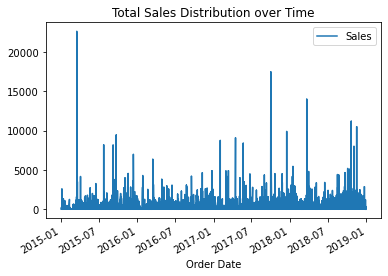

In [23]:
# Plotting the data to understand the sales distribution from the year 2015-2018
time_series_data.plot(title="Total Sales Distribution over Time");

In [24]:
time_series_data =  pd.DataFrame(time_series_data['Sales'].resample('M').sum())
time_series_data = time_series_data.interpolate(method='linear') #The interpolate() function is used to interpolate values according to different methods. It ignore the index and treats the values as equally spaced.

In [25]:
time_series_data.head()

,Sales
Order Date,
2015-01-31,14205.707
2015-02-28,4519.892
2015-03-31,55205.797
2015-04-30,27906.855
2015-05-31,23644.303


As seen, the total sales in each month have been recorded making the data much cleaner and time series analysis friendly!

## 4. Time Series Analysis

### 4.1 Create train and test set

In [26]:
# Taking an 80-20 Split!
data_len = len(time_series_data)
forecast_steps = data_len-int((data_len)*0.8)

train = time_series_data[:data_len-forecast_steps]
test = time_series_data[data_len-forecast_steps:]

### 4.2 Checking Stationarity - Augmented Dicky Fuller Test

**Augmented Dicky Fuller test**



* The Augmented Dickey-Fuller test is a type of statistical test also called a unit root test. The base of unit root test is that it helps in determining how strongly a time series is defined by a trend.

* The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary. The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

    1. Null Hypothesis(H0): Time series is not stationary
    2. Alternate Hypothesis (H1): Time series is stationary

* This result is interpreted using the p-value from the test. 

   1. p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
   2. p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [27]:
adf = adfuller(train) 

print(adf)
print('\nADF = ', str(adf[0])) # more towards negative value the better
print('\np-value = ', str(adf[1]))
print('\nCritical Values: ')

for key, val in adf[4].items(): # for loop to print the p-value (1%, 5% and 10%) and their respective values
    print(key,':',val)
    

    if adf[0] < val:
        print('Null Hypothesis Rejected. Time Series is Stationary')
    else:
        print('Null Hypothesis Accepted. Time Series is not Stationary')

(-4.1479521824590035, 0.0008060981043650675, 1, 36, {'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}, 616.3998453806314)

ADF =  -4.1479521824590035

p-value =  0.0008060981043650675

Critical Values: 
1% : -3.626651907578875
Null Hypothesis Rejected. Time Series is Stationary
5% : -2.9459512825788754
Null Hypothesis Rejected. Time Series is Stationary
10% : -2.6116707716049383
Null Hypothesis Rejected. Time Series is Stationary


Whew! Our time series is **stationary**. In case it was not, we would have to proceed with making the time series stationary using the various methods like differencing or transformations.

Note: Make sure to transform it back while making predictions.

### 4.3 Plotting ACF and PACF

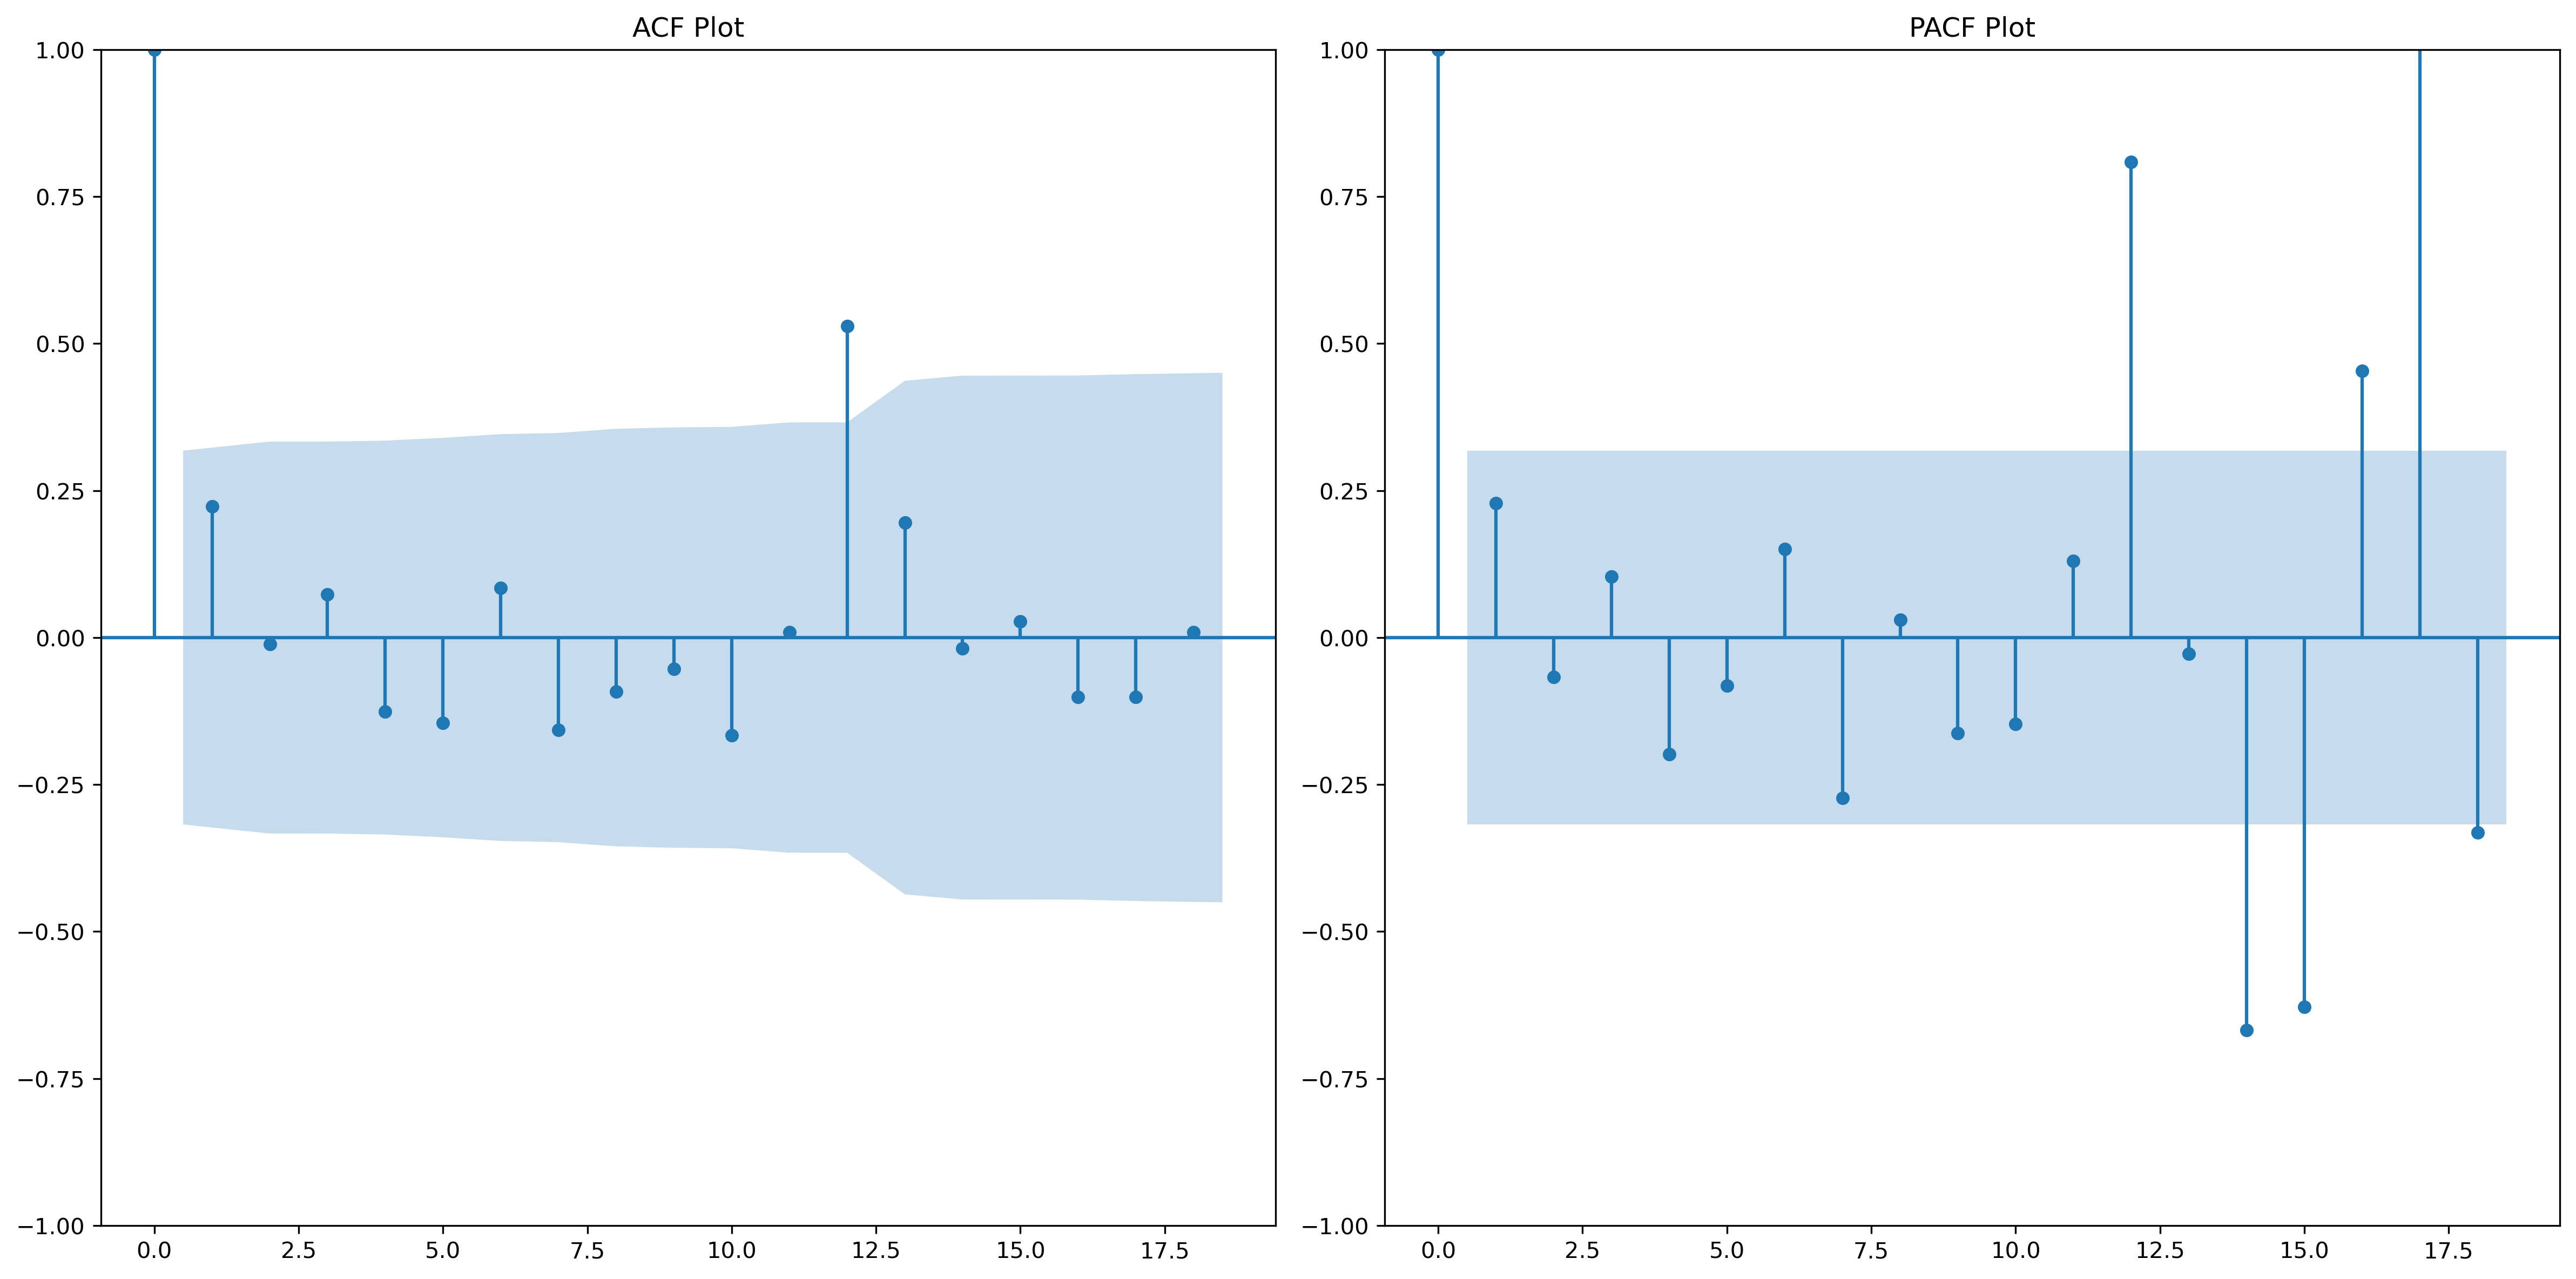

In [28]:
# Determine the maximum number of lags
max_lags = len(train) // 2 - 1

# Set the size and resolution of the plot
plt.figure(figsize=(16, 8), dpi=300)

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(train['Sales'], ax=plt.gca(), lags=max_lags)
plt.title('ACF Plot')

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(train['Sales'], ax=plt.gca(), lags=max_lags)
plt.title('PACF Plot')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

* ACF and PACF both represent heavy dependency on lag 12
* This indicates that out time series probably has an annual seasonality

Let's check that out!

### 4.4 Checking Seasonality

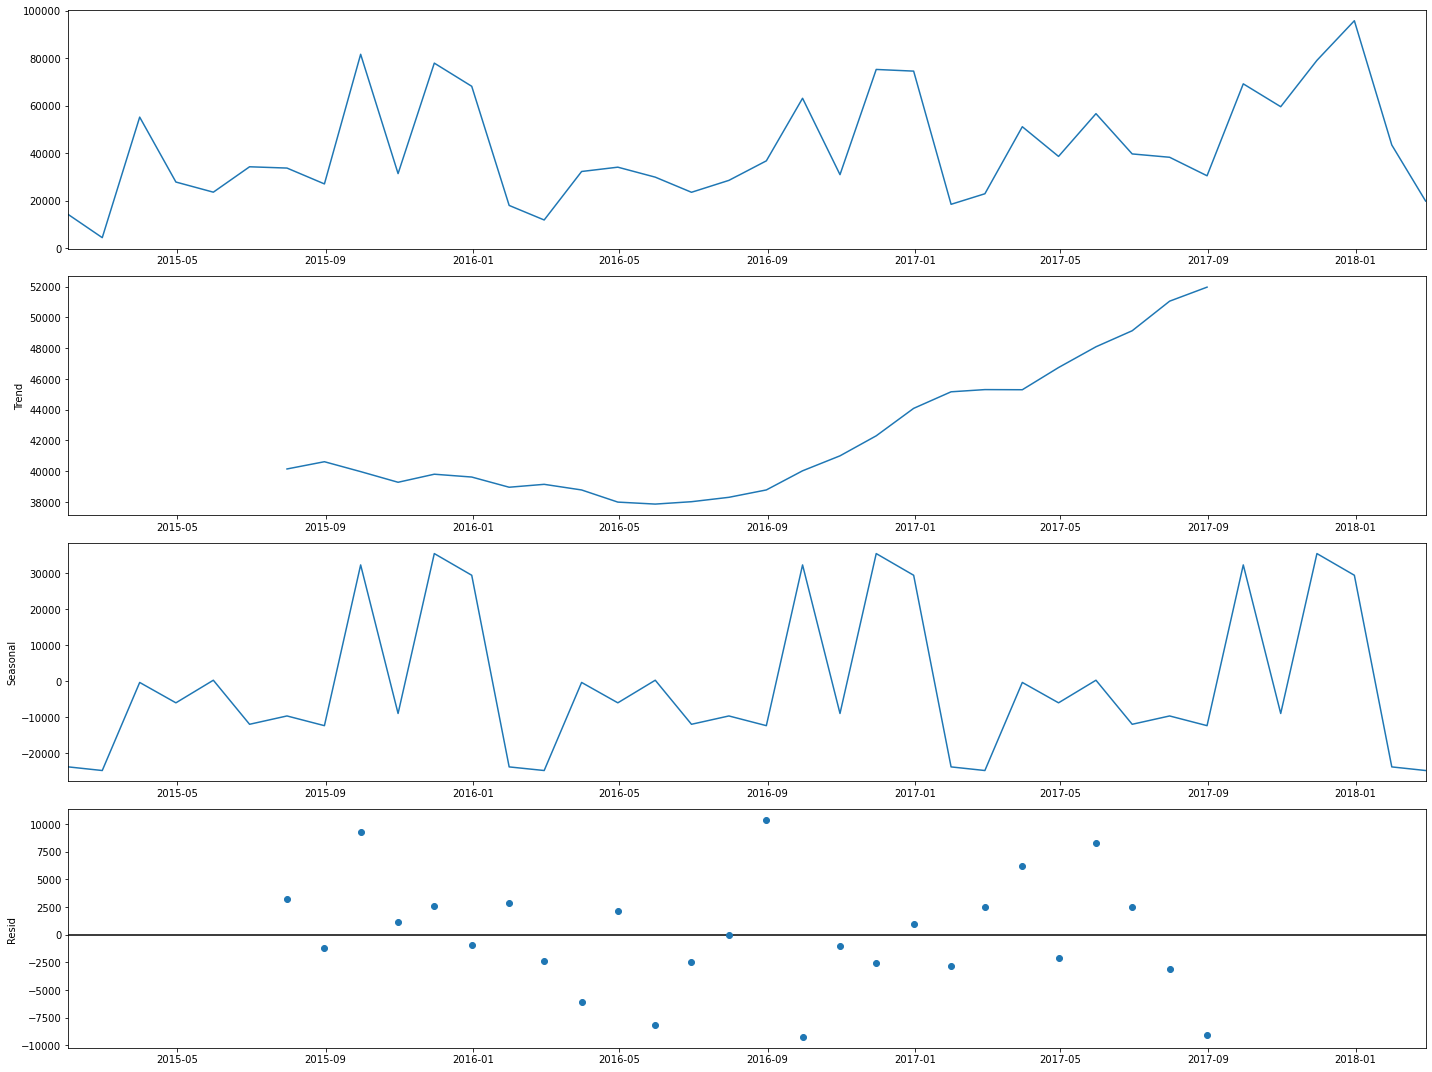

In [29]:
rcParams['figure.figsize'] = 20, 15

decomposition = sm.tsa.seasonal_decompose(train, model='additive') #function used to decompose Time Series Data into Trend and Seasonality
fig = decomposition.plot()
plt.show();

After decomposition, we have found that a seasonality does indeed exist! Visually looking at the seasonality graph, we can make out that it repeats annualy.

* SARIMA would be the ideal perfect model to forecast this trend. How do we decide the parameters? Grid Search!

### 4.5 SARIMA 

#### 4.5.1 Grid Search for ideal parameters

In [30]:
p = d = q = range(0, 2) 
pdq = list(itertools.product(p, d, q))
seasonal_pdq_comb = [(i[0], i[1], i[2], 12) for i in list(itertools.product(p, d, q))] #for loop for creating combinations of seasonal parameters of SARIMA
print('Examples of parameter combinations for Seasonal ARIMA:')
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq_comb[1]))
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq_comb[2]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq_comb[3]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq_comb[4]))

Examples of parameter combinations for Seasonal ARIMA:
SARIMA: (0, 0, 1) x (0, 0, 1, 12)
SARIMA: (0, 0, 1) x (0, 1, 0, 12)
SARIMA: (0, 1, 0) x (0, 1, 1, 12)
SARIMA: (0, 1, 0) x (1, 0, 0, 12)


**The Akaike information criterion (AIC)** is an estimator of out-of-sample prediction error and thereby relative quality of statistical models for a given set of data. AIC estimates the relative amount of information lost by a given model. The less information a model loses, the higher the quality of that model. **Lesser the AIC, better the model!**

In [31]:
for parameters in pdq: #for loop for determining the best combination of seasonal parameters for SARIMA
    for seasonal_param in seasonal_pdq_comb:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=parameters,
                                            seasonal_param_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False) #determines the AIC value of the model**
            results = mod.fit()
            print('SARIMA{}x{} - AIC:{}'.format(parameters, seasonal_param, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:905.2046244293599
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:905.2046244293599
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:905.2046244293599
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:905.2046244293599
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:905.2046244293599
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:905.2046244293599
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:905.2046244293599
SARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:905.2046244293599
SARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:866.0610648655959
SARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:866.0610648655959
SARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:866.0610648655959
SARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:866.0610648655959
SARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:866.0610648655959
SARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:866.0610648655959
SARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:866.0610648655959
SARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:866.0610648655959
SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:841.6346696113635
SARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:841.6346696113635
SARIMA(0, 1, 0)x(0, 1, 0, 12

We're going to go with **SARIMA(1, 1, 1)x(1, 1, 1, 12)** as it provides the lowest AIC score. There are other parameters with a similar score but I do not want to risk missing out on any seasonal component.

#### 4.5.2 Model building

In [32]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarima = mod.fit()
print(sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2499      0.668     -0.374      0.708      -1.559       1.059
ma.L1         -0.9858      0.982     -1.004      0.315      -2.911       0.939
ar.S.L12      -0.0089      3.450     -0.003      0.998      -6.771       6.753
ma.S.L12      -0.0802      3.795     -0.021      0.983      -7.517       7.357
sigma2      1.676e+08   1.87e-08   8.98e+15      0.000    1.68e+08    1.68e+08


#### 4.5.3 Results

##### 4.5.3.1 Performance on  test data

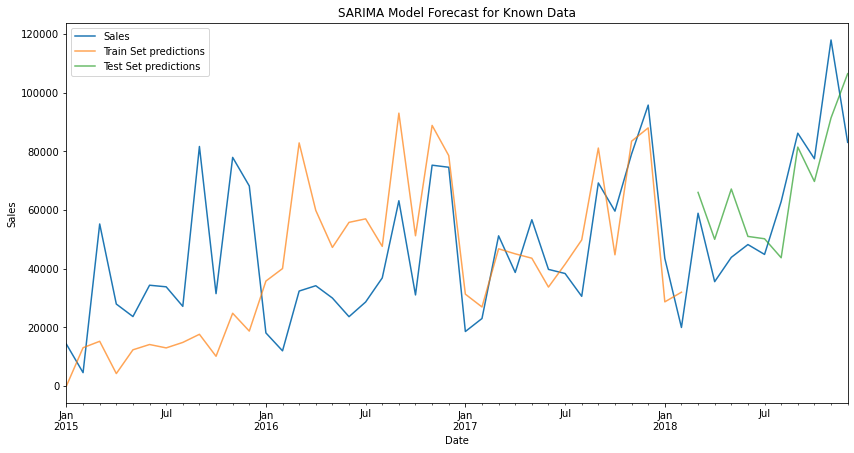

In [33]:
pred_train = sarima.get_prediction(start=pd.to_datetime('2015-01-31'), dynamic=False) # variable to display plot for predicted values
pred_test = sarima.forecast(steps=forecast_steps) # variable to display plot for predicted values

# pred_val = pred.conf_int()
ax = time_series_data['2014':].plot(label='observed') # displays plot for original values
pred_train.predicted_mean.plot(ax=ax, label='Train Set predictions', alpha=.7, figsize=(14, 7)) # displays plot for predicted values
pred_test.plot(ax=ax, label='Test Set predictions', alpha=.7, figsize=(14, 7)) # displays plot for predicted values

# ax.fill_between(pred_val.index,
#                 pred_val.iloc[:, 0],
#                 pred_val.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('SARIMA Model Forecast for Known Data')
plt.legend()
plt.show()

In [34]:
mae = mean_absolute_error(test['Sales'], pred_test.to_frame()['predicted_mean'])
print(f"Mean Absolute Error (MAE) for Sarima Model on Test Set: {mae:.2f}")

Mean Absolute Error (MAE) for Sarima Model on Test Set: 13455.42


##### 4.5.3.2 Forecasting unknown data

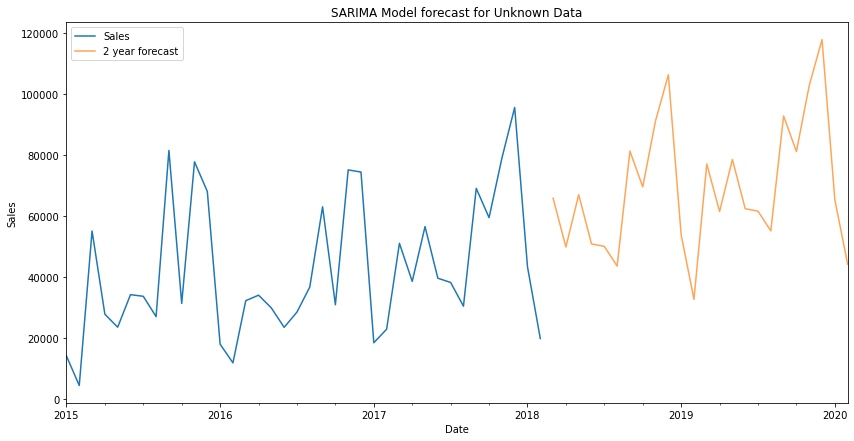

In [35]:
pred = sarima.forecast(steps=24) # variable to display plot for predicted values
ax = train['2014':].plot(label='observed') # displays plot for original values
pred.plot(ax=ax, label='2 year forecast', alpha=.7, figsize=(14, 7)) # displays plot for predicted values

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('SARIMA Model forecast for Unknown Data')
plt.legend()
plt.show()

That forecast looks satisfactory! Can we get better? Let's try out facebook's state-of-the-art time series model **Prophet**

### 4.6 Prophet Model 

#### 4.6.1 Data Setup

In [36]:
ts_prophet = time_series_data.reset_index()
ts_prophet = ts_prophet[["Order Date", "Sales"]]
ts_prophet.columns = ['ds', 'y']

In [37]:
train_prophet = ts_prophet.iloc[:data_len-forecast_steps]
test_prophet = ts_prophet.iloc[data_len-forecast_steps:forecast_steps+data_len]

#### 4.6.2 Model Building 

In [38]:
model = Prophet()
model.fit(train_prophet)

22:44:43 - cmdstanpy - INFO - Chain [1] start processing
22:44:43 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
future_test = test_prophet[['ds']]
forecast_test = model.predict(future_test)

In [40]:
future_train = train_prophet[['ds']]
forecast_train = model.predict(future_train)

#### 4.6.3 Results

##### 4.6.3.1 Performance on Test Set

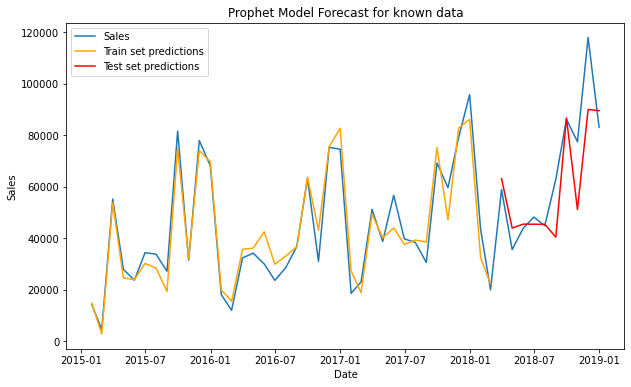

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(ts_prophet['ds'], ts_prophet['y'], label='Sales')
plt.plot(forecast_train['ds'], forecast_train['yhat'], label='Train set predictions', color='orange')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Test set predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Prophet Model Forecast for known data')
plt.legend()
plt.show()

In [42]:
actual = test_prophet['y'].values
forecasted = forecast_test['yhat'].values
mae = mean_absolute_error(actual, forecasted)
print(f"Mean Absolute Error (MAE) for Prophet Model on Test Set: {mae:.2f}")

Mean Absolute Error (MAE) for Prophet Model on Test Set: 10128.55


The error has gone down from 13455.42 (SARIMA) to 10128.55 (Prophet)! Prophet model forecasts the sales better.

##### 4.6.3.2 Performance on Unknown Data

In [43]:
future_d = model.make_future_dataframe(periods=24, freq='M')
forecast_d = model.predict(future_d)

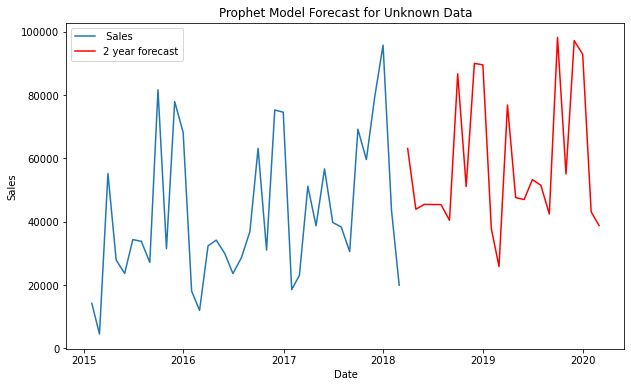

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(train_prophet['ds'], train_prophet['y'], label=' Sales')
plt.plot(forecast_d['ds'][-24:], forecast_d['yhat'][-24:], label='2 year forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Prophet Model Forecast for Unknown Data')
plt.legend()
plt.show()